# <font color="yellow">Remarks</font>
This notebook is based on a Tutorial notebook on the tensorflow web site.

1.	Custom training: basics  |  TensorFlow. TensorFlow. https://www.tensorflow.org/tutorials/eager/custom_training. Published December 17, 2018. Accessed December 29, 2018.

You can find some more insformation on eager execution, also on Tensorflow's website:
2.	Eager Execution  |  TensorFlow. TensorFlow. https://www.tensorflow.org/guide/eager. Published December 12, 2018. Accessed December 29, 2018.



<font color="yellow">We have marked sections that have differences with the original workbook in yellow</font>.
    
Author: H. Felix Wittmann
hfwittmann@gmail.com

There is no association between the author and Tensorflow.


##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom training: basics

In the previous tutorial we covered the TensorFlow APIs for automatic differentiation, a basic building block for machine learning.
In this tutorial we will use the TensorFlow primitives introduced in the prior tutorials to do some simple machine learning.

TensorFlow also includes a higher-level neural networks API (`tf.keras`) which provides useful abstractions to reduce boilerplate. We strongly recommend those higher level APIs for people working with neural networks. However, in this short tutorial we cover neural network training from first principles to establish a strong foundation.

## Setup

In [429]:
import numpy as np
import tensorflow as tf

tf.enable_eager_execution()

## Variables

Tensors in TensorFlow are immutable stateless objects. Machine learning models, however, need to have changing state: as your model trains, the same code to compute predictions should behave differently over time (hopefully with a lower loss!). To represent this state which needs to change over the course of your computation, you can choose to rely on the fact that Python is a stateful programming language:


In [430]:
# Using python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow, however, has stateful operations built in, and these are often more pleasant to use than low-level Python representations of your state. To represent weights in a model, for example, it's often convenient and efficient to use TensorFlow variables.

A Variable is an object which stores a value and, when used in a TensorFlow computation, will implicitly read from this stored value. There are operations (`tf.assign_sub`, `tf.scatter_update`, etc) which manipulate the value stored in a TensorFlow variable.

In [431]:
v = tf.contrib.eager.Variable(1.0)
assert v.numpy() == 1.0

# Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

In [432]:
np.arctan(1)/np.pi

0.25

In [433]:
np.tan(np.pi/4)

0.9999999999999999

Computations using Variables are automatically traced when computing gradients. For Variables representing embeddings TensorFlow will do sparse updates by default, which are more computation and memory efficient.

Using Variables is also a way to quickly let a reader of your code know that this piece of state is mutable.

## Example: Fitting a linear model

Let's now put the few concepts we have so far ---`Tensor`, `GradientTape`, `Variable` --- to build and train a simple model. This typically involves a few steps:

1. Define the model.
2. Define a loss function.
3. Obtain training data.
4. Run through the training data and use an "optimizer" to adjust the variables to fit the data.

In this tutorial, we'll walk through a trivial example of a simple linear model: `f(x) = x * W + b`, which has two variables - `W` and `b`. Furthermore, we'll synthesize data such that a well trained model would have `W = 3.0` and `b = 2.0`.

## Config

In [434]:
loss_function_tweak = 4

### Define the model

Let's define a simple class to encapsulate the variables and the computation.

In [435]:
class Model(object):
  def __init__(self):
    # Initialize variable to (5.0, 0.0)
    # In practice, these should be initialized to random values.
    self.Phi = tf.Variable(np.pi/4) # corresponds to 45 degrees
    # self.b = tf.Variable(0.0)
    
  def __call__(self, x):
    return tf.math.tan(self.Phi) * x # + self.b
  
model = Model()

assert model(1.0).numpy() == 1.0

### Define a loss function

A loss function measures how well the output of a model for a given input matches the desired output. Let's use the standard L2 loss.

In [436]:
def loss(predicted_y, desired_y):
  return tf.reduce_mean(((predicted_y - desired_y)**2)**(1/loss_function_tweak))

### <font color='yellow'>Obtain training data</font>

Let's synthesize the training data with some noise.

In [437]:
import matplotlib.pyplot as plt

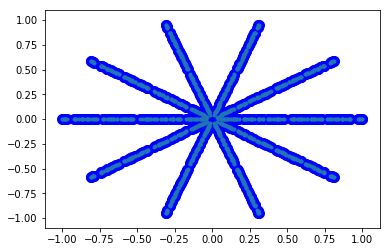

In [438]:
import numpy as np
nOfDatapoints = 100
amountOfNoise = 0.00

n = 6
phis = np.linspace(0, 2*np.pi, n)[:-1]

np.random.seed(314)
r =  np.random.uniform(size=nOfDatapoints)


for ix, phi in enumerate(phis):
    
    x1 = np.cos(phi) * np.hstack([r, -r])
    y1 = np.sin(phi) * np.hstack([r, -r])
    
    plt.scatter(x1,y1,marker='o', s=100, c='b')
    

    noise_local = np.random.normal(size=nOfDatapoints*2)
    outputs_local = y1 + noise_local*amountOfNoise
    
    if ix>0:
        inputs = np.hstack([inputs, x1])
        outputs = np.hstack([outputs, outputs_local])
    if ix==0:
        inputs = x1
        outputs = outputs_local
        
        
    
plt.plot(inputs, outputs, '.')
plt.show()

### <font color='yellow'>Split into train/test</font>

In [439]:
from sklearn.model_selection import train_test_split
inputs_train, inputs_test, outputs_train, outputs_test = \
    train_test_split(inputs, outputs, test_size=0.33, random_state=42)
# outputs = outputs.reshape(-1,1)  # reshape to match keras output

Current loss: 
0.61348486


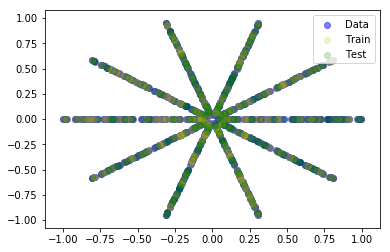

In [440]:
import matplotlib.pyplot as plt
plt.scatter(inputs,outputs,c='b', alpha=0.5, label='Data')
plt.scatter(inputs_train, outputs_train, c='y', alpha=0.2, label='Train')
plt.scatter(inputs_test, outputs_test, c='g', alpha=0.2, label='Test')
plt.legend()## Explore data und Model

# model = Model()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

### <font color='yellow'>Explore data und Model before training</font>

Before we train the model let's visualize where the model stands right now. We'll plot the model's predictions in black and the testting data in blue.

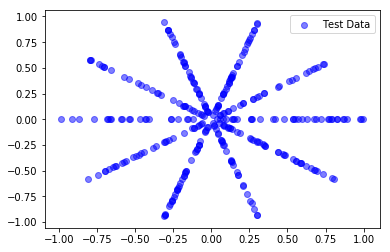

In [441]:
model = Model()

prediction_test = model(inputs_test).numpy()
plt.scatter(inputs_test, outputs_test, c = 'b', alpha=0.5, label = 'Test Data')
# plt.scatter(inputs_test, prediction_test, c = 'k', alpha=0.5, label = 'Initial Model Guess')
plt.legend()
plt.show()

### Define a training loop

We now have our network and our training data. Let's train it, i.e., use the training data to update the model's variables (`W` and `b`) so that the loss goes down using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer` implementations. We'd highly recommend using those implementations, but in the spirit of building from first principles, in this particular example we will implement the basic math ourselves.

### <font color='yellow'> Define gradient tape </font>

In [442]:
def grad(model, inputs, outputs):
    with tf.GradientTape() as tape:
        current_loss = loss(model(inputs), outputs)
    return current_loss, tape.gradient(current_loss, [model.Phi] )
    # return current_loss, tape.gradient(current_loss, [model.Phi, model.b] )

Finally, let's repeatedly run through the training data and see how `W` and `b` evolve.

### <font color='yellow'> Define standard optimizer </font>

In [443]:
learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
global_step = tf.Variable(0)

Epoch  0: W=0.79 loss=0.61413
Epoch  1: W=0.76 loss=0.60321
Epoch  2: W=0.74 loss=0.59192
Epoch  3: W=0.71 loss=0.57992
Epoch  4: W=0.69 loss=0.56660
Epoch  5: W=0.66 loss=0.55036
Epoch  6: W=0.63 loss=0.51846
Epoch  7: W=0.45 loss=0.54361
Epoch  8: W=0.45 loss=0.54356
Epoch  9: W=0.45 loss=0.54351
Epoch 10: W=0.45 loss=0.54346
Epoch 11: W=0.44 loss=0.54341
Epoch 12: W=0.44 loss=0.54336
Epoch 13: W=0.44 loss=0.54330
Epoch 14: W=0.44 loss=0.54324
Epoch 15: W=0.44 loss=0.54317
Epoch 16: W=0.44 loss=0.54310
Epoch 17: W=0.43 loss=0.54303
Epoch 18: W=0.43 loss=0.54295
Epoch 19: W=0.43 loss=0.54287
Epoch 20: W=0.43 loss=0.54279
Epoch 21: W=0.43 loss=0.54270
Epoch 22: W=0.42 loss=0.54261
Epoch 23: W=0.42 loss=0.54251
Epoch 24: W=0.42 loss=0.54241
Epoch 25: W=0.42 loss=0.54230
Epoch 26: W=0.41 loss=0.54218
Epoch 27: W=0.41 loss=0.54207
Epoch 28: W=0.41 loss=0.54194
Epoch 29: W=0.41 loss=0.54181
Epoch 30: W=0.40 loss=0.54168
Epoch 31: W=0.40 loss=0.54154
Epoch 32: W=0.40 loss=0.54139
Epoch 33: 

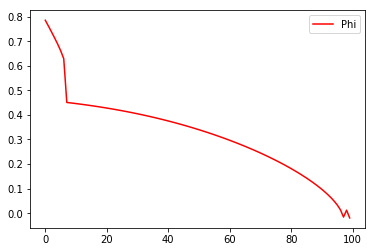

In [454]:
learning_rate = 0.05
model = Model()

# Collect the history of W-values and b-values to plot later
Phis, bs, losses = [], [], []
epochs = range(100)
for epoch in epochs:
    Phis.append(model.Phi.numpy())
    # bs.append(model.b.numpy())

    
    current_loss, [dPhi] = grad(model, inputs_train, outputs_train)
    
    losses.append(current_loss)
    
    # start : # variant a
    # model.W.assign_add(-learning_rate*dW)
    # model.b.assign_add(-learning_rate*db)
    # stop : # # variant a
    
    # start : variant b
    # the GradientDescentOptimizer is equivalent to variant a
    optimizer.apply_gradients( zip([dPhi], [model.Phi]), global_step)
    # stop : variant b
    
    print('Epoch %2d: W=%1.2f loss=%2.5f' %
        (epoch, Phis[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Phis, 'r')
plt.legend(['Phi','true Phi'])
plt.show()
  

### <font color='yellow'>A more abstract representation is the loss function</font>

Text(0.5, 1.0, 'Evolution of loss')

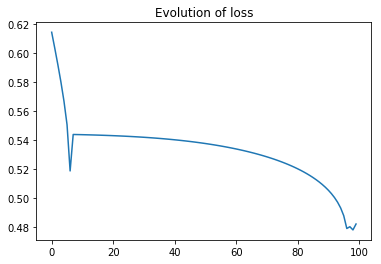

In [455]:
# Let's plot the history
plt.plot(losses)
plt.title('Evolution of loss')

## Next Steps

In this tutorial we covered `Variable`s and built and trained a simple linear model using the TensorFlow primitives discussed so far.

In theory, this is pretty much all you need to use TensorFlow for your machine learning research.
In practice, particularly for neural networks, the higher level APIs like `tf.keras` will be much more convenient since it provides higher level building blocks (called "layers"), utilities to save and restore state, a suite of loss functions, a suite of optimization strategies etc.


## <font color="yellow">Explore data und Model after training</font>

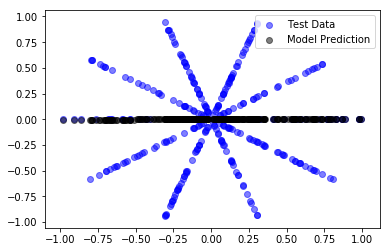

In [457]:
# model = Model()

prediction_test = model(inputs_test).numpy()
plt.scatter(inputs_test, outputs_test, c = 'b', alpha=0.5, label = 'Test Data')
plt.scatter(inputs_test, prediction_test, c = 'k', alpha=0.5, label = 'Model Prediction')
plt.legend()
plt.show()

## <font color='yellow'>Explore loss function</font>

In [458]:
def myloss(Phi,b):
    return (((inputs * np.tan(Phi) + b - outputs) ** 2)**(1/loss_function_tweak)).mean()

##  <font color='yellow'>Calculate loss surface</font>

In [459]:
mean = [0,0]
cov = [[np.pi/2,0],[0,0.0]]
Phib = np.random.multivariate_normal(mean=mean, cov=cov, size=2000)
Phi, b = Phib[:,0], Phib[:,1]
myloss_surface = [myloss(Phi,b) for (Phi,b) in Phib]

## Prepare plotting

In [460]:
# https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=Xbey0KVpfIbQ
from plotly.offline import iplot, plot, init_notebook_mode
import plotly.graph_objs as go
import numpy as np

In [461]:
loss

<function __main__.loss(predicted_y, desired_y)>

### <font color='yellow'>Calculate the trace for the surface data</font>

In [462]:
trace = go.Scatter3d(
    x = np.cos(Phi),
    y = np.sin(Phi),
    z = myloss_surface,
    mode='markers',
    marker = dict(
        opacity = 0.7,
        size = 3,
        color = myloss_surface
    ),
    name = 'General Surface'
)

data = [trace]
layout = go.Layout(
    title='Loss function',
    scene = dict (
        xaxis =  dict(title='Phi'),
        yaxis = dict(title='b'),
        zaxis = dict(title='loss', range =[0.0,1.5])
    )
)


### <font color='yellow'> Calculate the trace for the steps of the gradient based optimisation</font>

In [463]:
trace2 = go.Scatter3d(
    x = np.cos(Phis),
    y = np.sin(Phis),
    z = np.array(losses),
    mode='lines+markers',
    marker = dict(
        opacity = 1,
        size = 7,
        color = list(range(len(Phis))),
        colorscale = 'Jet'
    ),
    name = 'Gradient-based Optimisation'
)

data = [trace, trace2]

layout = go.Layout(
    title='Loss function' + '<br>' + 'loss_function_tweak = 4',
    scene = dict (
        xaxis =  dict(title='Phi'),
        yaxis = dict(title='b'),
        zaxis = dict(title='loss', range=[0.0,1.5])
    )
)

# iplot({'data':data, 'layout': layout})
plot({'data':data, 'layout': layout},'loss function.html')

'file:///Users/u712228/Lufthansa/HFW_Personal/comparison-tensorflow-keras/temp-plot.html'